In [13]:
import pandas as pd
import numpy as np
import joblib
import os

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from dotenv import load_dotenv

from datetime import date
from datetime import timedelta

import yfinance as yf

%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
def get_stock_data(symbols, start_date, end_date):
    stock_data = {}
    for symbol in symbols:
        stock = yf.download(symbol, start=start_date, end=end_date)
        stock_data[symbol] = stock
    return stock_data

# Setup for end_date, calling on last full day.
today = date.today()

# Getting the initial date ranges for review
start_date = date(2018,1,1)
end_date = today - timedelta(days = 1)

symbols = ['AAPL','MSFT','AMZN', 'NVDA']

stock_data = get_stock_data(symbols, start_date, end_date)

for symbol in symbols:
    stock = stock_data[symbol]
    
stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,48.945000,49.875000,48.625000,49.837502,49.326298,35561600
2018-01-03,51.025002,53.424999,50.937500,53.117500,52.572655,91470400
2018-01-04,53.939999,54.512501,53.172501,53.397499,52.849773,58326800
2018-01-05,53.547501,54.227501,52.770000,53.849998,53.297630,58012400
2018-01-08,55.099998,56.250000,54.645000,55.500000,54.930710,88121600
...,...,...,...,...,...,...
2023-04-06,265.839996,270.799988,264.269989,270.369995,270.369995,39765400
2023-04-10,268.230011,276.209991,266.690002,275.790009,275.790009,39527900
2023-04-11,277.239990,277.899994,271.260010,271.690002,271.690002,31437800


In [15]:
def generate_signals(df, short_window=30, long_window=120):
    # Compute the Exponential Moving Averages
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Initialize the Signal column
    df['Signal'] = 0.0
    
    # When the short EMA is above the long EMA, generate a signal to buy long
    df.loc[(df['EMA_short'] >= df['EMA_long']), 'Signal'] = 1
    
    # When the short EMA is below the long EMA, generate a signal to sell short
    df.loc[(df['EMA_short'] < df['EMA_long']), 'Signal'] = -1
    
    # Calculate the daily returns and add them to the DataFrame
    df['Returns'] = df['Close'].pct_change()
    df = df.dropna()
    
    # Calculate the strategy returns and add them to the DataFrame
    df['StrategyReturns'] = df['Returns'] * df['Signal'].shift()
    
    return df


def preprocess_data(X_train, X_test):
    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X_train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    joblib.dump(X_scaler, 'X_scaler.joblib')
    
    return X_train_scaled, X_test_scaled


def train_model(X_train, y_train):
    # Instantiate the SVC classifier model
    svm_model = SVC(kernel='rbf', C=1, gamma=0.1)
 
    # Fit the model to the data using the training data
    svm_model = svm_model.fit(X_train, y_train)
    
    joblib.dump(svm_model, 'svm_model.joblib')

    return svm_model


def evaluate_model(model, X_test, y_test):
    # Use the testing data to make the model predictions
    y_pred = model.predict(X_test)
    
    # Use a classification report to evaluate the model using the predictions and testing data
    report = classification_report(y_test, y_pred)
    
    return report


def generate_trading_signals(df, model, X_scaler):
    # Select the last row of the DataFrame and drop the Signal column
    last_row = df.iloc[-1].drop('Signal')

    # Shift the last row and convert it to a DataFrame
    X = pd.DataFrame(last_row).T

    # Scale the features using the X_scaler
    X_scaled = X_scaler.transform(X)

    # Use the model to predict the signal for the next day
    signal = model.predict(X_scaled)[0]

    # Return the predicted signal
    return signal


def backtest_strategy(df, model, X_scaler):
    # Generate trading signals using the model and X_scaler
    df['Signal'] = df.apply(lambda x: generate_trading_signals(df[:x.name], model, X_scaler), axis=1)

    # Calculate the daily returns and add them to the DataFrame
    df['Returns'] = df['Close'].pct_change()

    # Calculate the strategy returns and add them to the DataFrame
    df['StrategyReturns'] = df['Returns'] * df['Signal'].shift()

    # Calculate the cumulative returns and add them to the DataFrame
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod()

    # Calculate the annualized return
    annualized_return = (df['CumulativeReturns'][-1]) ** (252/len(df.index)) - 1

    # Calculate the annualized volatility
    annualized_volatility = df['Returns'].std() * np.sqrt(252)

    # Calculate the Sharpe Ratio
    sharpe_ratio = annualized_return / annualized_volatility

    return df, annualized_return, annualized_volatility, sharpe_ratio

In [16]:
signals_df = generate_signals(stock).dropna()
signals_df

C:\Users\Elias\AppData\Local\Temp\ipykernel_47492\3204791354.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StrategyReturns'] = df['Returns'] * df['Signal'].shift()


,Open,High,Low,Close,Adj Close,Volume,EMA_short,EMA_long,Signal,Returns,StrategyReturns
Date,,,,,,,,,,,
2018-01-04,53.939999,54.512501,53.172501,53.397499,52.849773,58326800,50.265139,49.949663,1.0,0.005271,0.005271
2018-01-05,53.547501,54.227501,52.770000,53.849998,53.297630,58012400,50.496420,50.014132,1.0,0.008474,0.008474
2018-01-08,55.099998,56.250000,54.645000,55.500000,54.930710,88121600,50.819232,50.104807,1.0,0.030641,0.030641
2018-01-09,55.555000,55.955002,54.660000,55.485001,54.915855,49700000,51.120249,50.193736,1.0,-0.000270,-0.000270
2018-01-10,54.549999,55.955002,54.000000,55.919998,55.346401,58266400,51.429911,50.288385,1.0,0.007840,0.007840
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,265.839996,270.799988,264.269989,270.369995,270.369995,39765400,253.152104,206.772912,1.0,0.005803,0.005803
2023-04-10,268.230011,276.209991,266.690002,275.790009,275.790009,39527900,254.612614,207.913691,1.0,0.020047,0.020047
2023-04-11,277.239990,277.899994,271.260010,271.690002,271.690002,31437800,255.714381,208.967845,1.0,-0.014866,-0.014866


In [17]:
# Split the data into training and testing sets
train_size = int(len(signals_df) * 0.8)
train_data = signals_df[:train_size]
test_data = signals_df[train_size:]

# Preprocess the training and testing data
X_train, y_train = train_data.drop(['Signal'], axis=1), train_data['Signal']
X_test, y_test = test_data.drop(['Signal'], axis=1), test_data['Signal']
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

# Train the model
model = train_model(X_train_scaled, y_train)

In [18]:
# Evaluate the model
report = evaluate_model(model, X_test_scaled, y_test)
print(report)

              precision    recall  f1-score   support

        -1.0       1.00      0.21      0.35       185
         1.0       0.36      1.00      0.53        81

    accuracy                           0.45       266
   macro avg       0.68      0.61      0.44       266
weighted avg       0.80      0.45      0.40       266



In [19]:
# Generate trading signals for the entire DataFrame
X_scaler = StandardScaler().fit(X_train)
signals_df['Signal'] = signals_df.apply(lambda x: generate_trading_signals(signals_df[:x.name], model, X_scaler), axis=1)

In [20]:
# Backtest the strategy
backtest_results = backtest_strategy(signals_df, model, X_scaler)
print(backtest_results)

(                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-04   53.939999   54.512501   53.172501   53.397499   52.849773   
2018-01-05   53.547501   54.227501   52.770000   53.849998   53.297630   
2018-01-08   55.099998   56.250000   54.645000   55.500000   54.930710   
2018-01-09   55.555000   55.955002   54.660000   55.485001   54.915855   
2018-01-10   54.549999   55.955002   54.000000   55.919998   55.346401   
...                ...         ...         ...         ...         ...   
2023-04-06  265.839996  270.799988  264.269989  270.369995  270.369995   
2023-04-10  268.230011  276.209991  266.690002  275.790009  275.790009   
2023-04-11  277.239990  277.899994  271.260010  271.690002  271.690002   
2023-04-12  273.700012  274.679993  264.480011  264.950012  264.950012   
2023-04-13  267.339996  268.869995  263.290009  264.630005  264.630005   

              Volume   EMA_short    

In [21]:
# Download the SPY data
spy_data = get_stock_data(['SPY'], start_date, end_date)['SPY']
spy_returns = spy_data['Close'].pct_change()

[*********************100%***********************]  1 of 1 completed


In [22]:
strategy_returns = signals_df['StrategyReturns']
cumulative_strategy_returns = strategy_returns.cumsum()
cumulative_spy_returns = spy_returns.cumsum()

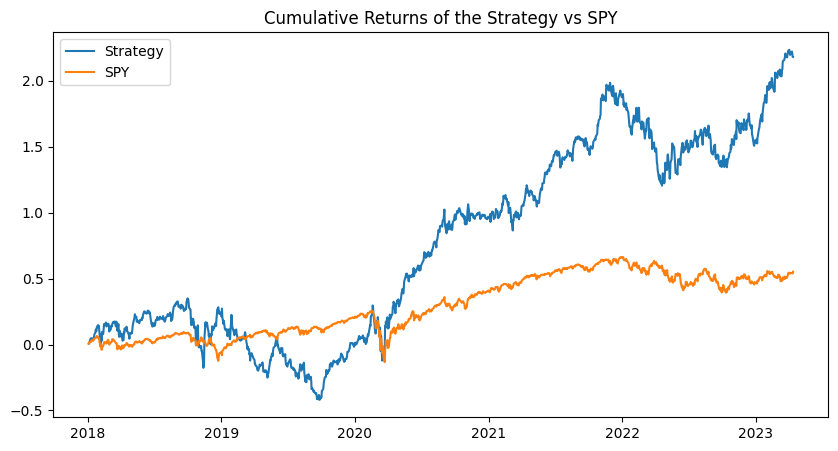

In [23]:
# Plot the cumulative returns of the strategy and SPY
plt.figure(figsize=(10, 5))
plt.plot(cumulative_strategy_returns, label='Strategy')
plt.plot(cumulative_spy_returns, label='SPY')
plt.legend()
plt.title('Cumulative Returns of the Strategy vs SPY')
plt.show()